Adding everything from Step-1.ipynb

# Modules import

In [3]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Reading data from CSV files

## I. For jester dataset
1. Read in joke id and joke text from 'datasets/jester_items.csv'.
2. Read in joke ratings from 'datasets/jester_ratings.csv'.

## II. For reddit jokes dataset
1. Read jokes from 'datasets/reddit_jokes.json'.
2. Unify the format for joke data.

## III. For stupid stuff jokes dataset
1. Read jokes from 'datasets/stupidstuff_shuffled.json'.
2. Unify the format for joke data.

In [4]:
# Read in the data

## Read in joke id and joke text
jester_joke_data = pd.read_csv('datasets/jester_items.csv')

## Read in joke ratings
jester_joke_ratings = pd.read_csv('datasets/jester_ratings.csv')

## Read reddit jokes and unify the format for the joke data
reddit_jokes = pd.read_json('datasets/reddit_jokes.json')
reddit_jokes['jokeId'] = reddit_jokes.id

## TODO: Add this dataframe to the jester_joke_data dataframe and update the index
reddit_jokes['jokeText'] = reddit_jokes['title'] + '\n' + reddit_jokes['body']
reddit_joke_data = reddit_jokes[['jokeId', 'jokeText']]

## Read stupidstuff.json and unify the format for the joke data
stupidstuff_jokes = pd.read_json('datasets/stupidstuff_shuffled.json')

## IV. For user ratings dataset
1. Map the user IDs for the 3 users.
  - Tanya: USF1000
  - Rishab: USF1001
  - Parisa: USF1002
2. Read the user ratings for each user saved in their respective files. Example, ratings by the user USF1000 is stored in the file, 'datasets/ratings_USF1000.csv'
3. Concatenate all the CSVs of user ratings into one dataframe.
4. Combine these ratings into the joke dataset such that each user has their own colum for ratings in the dataframe.
5. Finally drop duplicates and not required columns.

In [8]:
user_ids = [0, 1, 2]

user_ratings_files = [ 'datasets/ratings_USF100' + str(user_id) + '.csv' for user_id in user_ids ]

user_ratings = pd.concat([pd.read_csv(user_ratings_file) for user_ratings_file in user_ratings_files])

In [9]:
# We create new columns for all the jokes according to the user ratings

unique_user_ids = user_ratings['user_id'].unique()

for index, row in user_ratings.iterrows():

    user_num = row['user_id']
    joke_id = row['joke_id']

    joke_ratings = user_ratings[(user_ratings['joke_id'] == joke_id)]

    for user_id in unique_user_ids:
        ratings = joke_ratings[joke_ratings['user_id'] == user_id]['rating'].values
        if len(ratings) > 0:
            rating = int(ratings[0])
        else:
            rating = np.nan
        user_ratings.loc[index, (user_id + "_rating")] = rating

In [10]:
user_ratings.drop_duplicates(subset='joke_id', inplace=True)

user_ratings.drop(['user_id', 'rating'], axis=1, inplace=True)

## V. For na_user_ratings dataframe,
1. Add each joke's source to the user_ratings dataframe.
2. Separate user_ratings dataframe such that we extraact all jokes that are not rated by all users into another dataframe.

In [13]:
# print(user_ratings)

# user_ratings.joke_id.unique()

def add_source_column(row):
    joke_id = row['joke_id']

    if joke_id.startswith('RE'):
        temp_joke_id = joke_id[2:]
        row['source'] = "reddit"
        row['datasource_joke_id'] = temp_joke_id
        # user_ratings.loc[index, 'source'] = "reddit"
        # user_ratings.loc[index, 'datasource_joke_id'] = temp_joke_id

    elif joke_id.startswith('JE'):
        temp_joke_id = joke_id[2:]
        row['source'] = "jester"
        row['datasource_joke_id'] = temp_joke_id

    elif joke_id.startswith('SS'):
        temp_joke_id = joke_id[2:]
        row['source'] = "stupidstuff"
        row['datasource_joke_id'] = temp_joke_id

    return row


user_ratings = user_ratings.apply(add_source_column, axis=1)
print("NA values in user_ratings dataframe.")
print(user_ratings.isna().sum())

na_user_ratings = user_ratings[user_ratings.isna().any(axis=1)]

user_ratings.dropna(inplace=True)
print("\nNA values in user_ratings dataframe after cleaning.")
print(user_ratings.isna().sum())

NA values in user_ratings dataframe.
joke_id                 0
USF1000_rating        112
USF1001_rating        102
USF1002_rating          0
source                  0
datasource_joke_id      0
dtype: int64

NA values in user_ratings dataframe after cleaning.
joke_id               0
USF1000_rating        0
USF1001_rating        0
USF1002_rating        0
source                0
datasource_joke_id    0
dtype: int64


In [14]:
user_ratings

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id
0,RE5tz52q,1.0,8.0,0.0,reddit,5tz52q
1,RE5tz4dd,1.0,8.0,0.0,reddit,5tz4dd
2,RE5tz319,0.0,9.0,8.0,reddit,5tz319
3,RE5tz2wj,3.0,9.0,0.0,reddit,5tz2wj
4,RE5tz1pc,5.0,3.0,8.0,reddit,5tz1pc
...,...,...,...,...,...,...
63,SS2254,8.0,10.0,0.0,stupidstuff,2254
64,SS120,9.0,7.0,5.0,stupidstuff,120
65,SS816,9.0,10.0,0.0,stupidstuff,816
66,SS554,7.0,0.0,0.0,stupidstuff,554


## VI. For temp_df dataframe,
1. Merge all the joke texts from different joke datasets to start feature engineering and model training.
2. One hot encode the `source` feature and join in the `temp_df` dataframe.

In [15]:
# Merge the joke text with the user ratings

def merge_joke_text(row):
    joke_id = row['datasource_joke_id']
    joke_source = row['source']

    if joke_source == 'reddit':
        joke_text = reddit_joke_data[reddit_joke_data['jokeId'] == joke_id]['jokeText'].values
        if joke_text:
            row['jokeText'] = joke_text[0]
        else:
            print ("Joke not found for reddit with id: " + joke_id)
        
    elif joke_source == 'jester':
        joke_text = jester_joke_data[jester_joke_data['jokeId'] == int(joke_id)]['jokeText'].values
        if joke_text:
            row['jokeText'] = joke_text[0]
        else:
            print ("Joke not found for jester with id->" + joke_id)
        
    elif joke_source == 'stupidstuff':
        joke_id = int(joke_id)
        joke_text = stupidstuff_jokes[stupidstuff_jokes['jokeId'] == joke_id]['jokeText'].values
        
        if joke_text:
            row['jokeText'] = joke_text[0]
        else:
            print ("Joke not found for stupidstuff with id: " + joke_id)

    return row


temp_df = user_ratings.apply(merge_joke_text, axis=1)
temp_df

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText
0,RE5tz52q,1.0,8.0,0.0,reddit,5tz52q,I hate how you cant even say black paint anymo...
1,RE5tz4dd,1.0,8.0,0.0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...
2,RE5tz319,0.0,9.0,8.0,reddit,5tz319,I recently went to America....\n...and being t...
3,RE5tz2wj,3.0,9.0,0.0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave..."
4,RE5tz1pc,5.0,3.0,8.0,reddit,5tz1pc,You hear about the University book store worke...
...,...,...,...,...,...,...,...
63,SS2254,8.0,10.0,0.0,stupidstuff,2254,An old guy goes to the doctor and gets some te...
64,SS120,9.0,7.0,5.0,stupidstuff,120,"1. Capmbell's Soup Condoms: Mmm, mmmm, good....."
65,SS816,9.0,10.0,0.0,stupidstuff,816,A fireman is at the station house working outs...
66,SS554,7.0,0.0,0.0,stupidstuff,554,A husband and wife were having an argument. Su...


In [16]:
one_hot = pd.get_dummies(temp_df['source'])

temp_df = temp_df.join(one_hot)

joke_info_dataset = temp_df.drop('source',axis = 1)

## VI. For the users dataset
Read the users information from 'datasets/users.csv'.

In [17]:
users_info = pd.read_csv('datasets/users.csv')

users_info.head()

,user_id,name,age,gender,ethnicity,country,location,avg_user_rating,city,buddy
0,USF1000,Tanya,24,Female,South East Asian,India,San Francisco,5.968586,Delhi,USF1001
1,USF1001,rishab,26,Male,South East Asian,India,San Francisco,6.727749,Mumbai,USF1000
2,USF1002,Parisa,26,Female,Middle Eastern,Iran,San Francisco,0.806283,Ahvaz,USF1001


#### Working on Step 2 now

# Phase 2: Categorizing jokes’ abusive nature & sentiments using pre-trained BERT models

In [18]:
df = temp_df
df

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText,jester,reddit,stupidstuff
0,RE5tz52q,1.0,8.0,0.0,reddit,5tz52q,I hate how you cant even say black paint anymo...,0,1,0
1,RE5tz4dd,1.0,8.0,0.0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...,0,1,0
2,RE5tz319,0.0,9.0,8.0,reddit,5tz319,I recently went to America....\n...and being t...,0,1,0
3,RE5tz2wj,3.0,9.0,0.0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave...",0,1,0
4,RE5tz1pc,5.0,3.0,8.0,reddit,5tz1pc,You hear about the University book store worke...,0,1,0
...,...,...,...,...,...,...,...,...,...,...
245,SS1864,6.0,9.0,0.0,stupidstuff,1864,A martian landed in the country. He Went up to...,0,0,1
246,SS2624,6.0,4.0,0.0,stupidstuff,2624,"Jonathan took his college roommate, Jake, home...",0,0,1
247,SS1334,1.0,9.0,0.0,stupidstuff,1334,"""No clergyman shall tell a funny story from th...",0,0,1
248,SS2778,7.0,8.0,0.0,stupidstuff,2778,Q: How many 'Real Men' does it take to change ...,0,0,1


## Define function `assign_labels`
The pre-trained BERT models help in multi-class classification of our joke texts. We want to extract every joke's classification probability for each class and assign it to their respective probability.

In [19]:
# and fill it with the predicted probability for each row
def assign_labels(model, df, label_names):
    for index, row in df.iterrows():
        text = row['jokeText']
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        softmax = torch.softmax(logits, dim=1)
        predicted_probabilities = softmax.detach().numpy()[0]
        for i, label in enumerate(label_names):
            df.at[index, label] = predicted_probabilities[i]
    return df

## Pre-trained BERT models used
### I. For abusive nature
**Source**: [HuggingFace://unitary/toxic-bert](https://huggingface.co/unitary/toxic-bert)
#### Categories
1. Toxic
2. Obscene
3. Insult
4. Identity Hate
5. Threat
6. Severe Toxic

### II. For sentiments
**Source**: [HuggingFace://michellejieli/emotion_text_classifier](https://huggingface.co/michellejieli/emotion_text_classifier)
#### Categories
1. Anger
2. Disgust
3. Fear
4. Joy
5. Neutral
6. Sadness
7. Surprise

In [190]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

# tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")

# model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")
# pipeline =  TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
for model_path in ['unitary/toxic-bert', 'michellejieli/emotion_text_classifier']:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    label_names = list(model.config.id2label.values())
    df = assign_labels(model, df, label_names)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### III. For misogyny classification
**Source**: [HuggingFace://MilaNLProc/bert-base-uncased-ear-misogyny](https://huggingface.co/MilaNLProc/bert-base-uncased-ear-misogyny)
#### Categories
1. Misogynist
2. Non-misogynist

### IV. For sexism classification
**Source**: [HuggingFace://NLP-LTU/distilbert-sexism-detector](https://huggingface.co/NLP-LTU/distilbert-sexism-detector)
#### Categories
1. Sexist
2. Not Sexist

In [21]:
# MilaNLProc/bert-base-uncased-ear-misogyny
for model_path in ['MilaNLProc/bert-base-uncased-ear-misogyny', 'NLP-LTU/distilbert-sexism-detector']:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    label_names = list(model.config.id2label.values())
    print(f"Classification labels for {model_path}: ", label_names)
    for index, row in df.iterrows():
        text = row['jokeText']
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        softmax = torch.softmax(logits, dim=1)
        predicted_probabilities = softmax.detach().numpy()[0]
        for i, label in enumerate(label_names):
            if label in ['misogynist', 'sexist']:
                df.at[index, label] = predicted_probabilities[i]

Classification labels for MilaNLProc/bert-base-uncased-ear-misogyny:  ['non-misogynist', 'misogynist']
Classification labels for NLP-LTU/distilbert-sexism-detector:  ['not sexist', 'sexist']


-------------------------------------------------------------------------------

This is where we calculate the metrics for every demographic

-------------------------------------------------------------------------------

1. Read users data from the file, 'datasets/users.csv'.
2. Create one-hot encoded dataframe from users.
3. We calculate a sum by aggregating product of each user's rating by a particular demographics weight from the users dataframe.
4. We get 

In [22]:
users = pandas.read_csv('datasets/users.csv')

users_encoded = users.copy()
users_encoded = users_encoded.drop(columns=['name', 'user_id'], axis=1)
users_encoded['age'] = users['age'].astype(str)
users_encoded = pandas.get_dummies(users_encoded)

users_demographics = df.copy()
for index, row in df.iterrows():
    for col in users_encoded.columns:
        sum = 0
        # number_of_users is the number of rows in users_encoded
        number_of_users = len(users_encoded.index)
        for user_id in range(number_of_users):
            weight = users_encoded.at[user_id, col]
            rating = df.at[index, f'USF100{user_id}_rating']
            sum += weight * rating
        users_demographics.at[index, col] = sum / (number_of_users * 10)
users_demographics

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText,jester,reddit,stupidstuff,...,ethnicity_Middle Eastern,ethnicity_South East Asian,country_India,country_Iran,location_San Francisco,city_Ahvaz,city_Delhi,city_Mumbai,buddy_USF1000,buddy_USF1001
0,RE5tz52q,1.0,8.0,0.0,reddit,5tz52q,I hate how you cant even say black paint anymo...,0,1,0,...,0.000000,0.300000,0.300000,0.000000,0.300000,0.000000,0.033333,0.266667,0.266667,0.033333
1,RE5tz4dd,1.0,8.0,0.0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...,0,1,0,...,0.000000,0.300000,0.300000,0.000000,0.300000,0.000000,0.033333,0.266667,0.266667,0.033333
2,RE5tz319,0.0,9.0,8.0,reddit,5tz319,I recently went to America....\n...and being t...,0,1,0,...,0.266667,0.300000,0.300000,0.266667,0.566667,0.266667,0.000000,0.300000,0.300000,0.266667
3,RE5tz2wj,3.0,9.0,0.0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave...",0,1,0,...,0.000000,0.400000,0.400000,0.000000,0.400000,0.000000,0.100000,0.300000,0.300000,0.100000
4,RE5tz1pc,5.0,3.0,8.0,reddit,5tz1pc,You hear about the University book store worke...,0,1,0,...,0.266667,0.266667,0.266667,0.266667,0.533333,0.266667,0.166667,0.100000,0.100000,0.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,SS1864,6.0,9.0,0.0,stupidstuff,1864,A martian landed in the country. He Went up to...,0,0,1,...,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.200000,0.300000,0.300000,0.200000
246,SS2624,6.0,4.0,0.0,stupidstuff,2624,"Jonathan took his college roommate, Jake, home...",0,0,1,...,0.000000,0.333333,0.333333,0.000000,0.333333,0.000000,0.200000,0.133333,0.133333,0.200000
247,SS1334,1.0,9.0,0.0,stupidstuff,1334,"""No clergyman shall tell a funny story from th...",0,0,1,...,0.000000,0.333333,0.333333,0.000000,0.333333,0.000000,0.033333,0.300000,0.300000,0.033333
248,SS2778,7.0,8.0,0.0,stupidstuff,2778,Q: How many 'Real Men' does it take to change ...,0,0,1,...,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.233333,0.266667,0.266667,0.233333


#### Step 3

In [23]:
df = pandas.read_json("datasets/joke_info.json")
USF_users = pandas.read_csv('datasets/users.csv')

avg_user_rating = []
for index, row in USF_users.iterrows():
    user_id = row['user_id']
    avg_user_rating.append(df[f'{user_id}_rating'].mean())

USF_users['avg_user_rating'] = avg_user_rating


In [24]:
USF1002_ratings = pandas.read_csv('datasets/ratings_USF1002.csv')
# USF1002_ratings = USF1002_ratings[USF1002_ratings['joke_id'].str.startswith('JE')]

USF1000_ratings = pandas.read_csv('datasets/ratings_USF1000.csv')
# USF1000_ratings = USF1000_ratings[USF1000_ratings['joke_id'].str.startswith('JE')]

USF1001_ratings = pandas.read_csv('datasets/ratings_USF1001.csv')
# USF1001_ratings = USF1001_ratings[USF1001_ratings['joke_id'].str.startswith('JE')]

In [25]:
pred = pandas.DataFrame(columns=['joke_id', 'USF1002_rating', 'USF1000_rating', 'USF1001_rating'])
pred['joke_id'] = USF1002_ratings['joke_id']
pred['USF1002_rating'] = USF1002_ratings['rating']
pred['USF1000_rating'] = USF1000_ratings['rating']
pred['USF1001_rating'] = USF1001_ratings['rating']

In [26]:
extracted = pred.copy()
extracted = extracted.dropna()
extracted

,joke_id,USF1002_rating,USF1000_rating,USF1001_rating
0,JE1,0,0.0,8.0
1,JE2,0,2.0,8.0
2,JE3,8,3.0,7.0
3,JE4,0,2.0,9.0
4,JE5,8,0.0,8.0
...,...,...,...,...
263,SS2509,0,4.0,3.0
264,SS2262,0,7.0,8.0
265,SS785,0,8.0,2.0
266,SS746,0,8.0,9.0


In [27]:
# make a new  dataframe df2 that recalculates the ratings of all jokes by calculating the difference between the average rating of the user and the rating of the joke
# so for a user with id x in USF_users, the value of `x_rating` should be the difference between the average rating of the user from the USF_users dataframe and the rating of the joke from the df dataframe
# if a user has not rated any joke, the value of `x_rating` should be 0

df2 = df.copy()
for index, row in USF_users.iterrows():
    user_id = row['user_id']
    df2[f'{user_id}_rating'] =  row['avg_user_rating'] - df2[f'{user_id}_rating']

df2

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,datasource_joke_id,jokeText,jester,reddit,stupidstuff
0,RE5tz52q,5.10303,-1.206061,1.09697,5tz52q,I hate how you cant even say black paint anymo...,0,1,0
1,RE5tz4dd,5.10303,-1.206061,1.09697,5tz4dd,What's the difference between a Jew in Nazi Ge...,0,1,0
2,RE5tz319,6.10303,-2.206061,-6.90303,5tz319,I recently went to America....\n...and being t...,0,1,0
3,RE5tz2wj,3.10303,-2.206061,1.09697,5tz2wj,"Brian raises his hand and says, “He’s in Heave...",0,1,0
4,RE5tz1pc,1.10303,3.793939,-6.90303,5tz1pc,You hear about the University book store worke...,0,1,0
...,...,...,...,...,...,...,...,...,...
160,SS2771,-0.89697,-3.206061,1.09697,2771,Q: How many Field Service Engineers does it ta...,0,0,1
161,SS1365,-1.89697,-3.206061,1.09697,1365,Yo mamma so dumb she sold her car for gasoline...,0,0,1
162,SS570,-1.89697,3.793939,1.09697,570,"A woman gets home, schreeches her car into the...",0,0,1
163,SS431,-0.89697,-0.206061,1.09697,431,The psychology instructor had just finished a ...,0,0,1


In [28]:
similarity_matrix = pandas.DataFrame(index=USF_users['user_id'], columns=USF_users['user_id'])

for index, row in USF_users.iterrows():
    user_id = row['user_id']
    for index2, row2 in USF_users.iterrows():
        user_id2 = row2['user_id']
        similarity_matrix[user_id][user_id2] = (df2[f'{user_id}_rating'] * df2[f'{user_id2}_rating']).sum() / (numpy.sqrt((df2[f'{user_id}_rating']**2).sum()) * numpy.sqrt((df2[f'{user_id2}_rating']**2).sum()))

similarity_matrix

user_id,USF1000,USF1001,USF1002
user_id,,,
USF1000,1.0,0.257828,-0.109062
USF1001,0.257828,1.0,0.05376
USF1002,-0.109062,0.05376,1.0


### Calculate buddy here

In [29]:
USF_users['buddy'] = ''
for index, row in USF_users.iterrows():
    user_id = row['user_id']
    max_similarity = 0
    buddy = ''
    for index2, row2 in USF_users.iterrows():
        user_id2 = row2['user_id']
        if user_id2 != user_id and similarity_matrix[user_id][user_id2] > max_similarity:
            max_similarity = similarity_matrix[user_id][user_id2]
            buddy = user_id2
    USF_users.loc[index, 'buddy'] = buddy

USF_users

,user_id,name,age,gender,ethnicity,country,location,avg_user_rating,city,buddy
0,USF1000,Tanya,24,Female,South East Asian,India,San Francisco,6.103030,Delhi,USF1001
1,USF1001,rishab,26,Male,South East Asian,India,San Francisco,6.793939,Mumbai,USF1000
2,USF1002,Parisa,26,Female,Middle Eastern,Iran,San Francisco,1.096970,Ahvaz,USF1001


Step 4 from this point onwards

In [30]:
df = users_demographics

In [31]:
## This is our target user. Currently we're targeting jokes for Tanya -> USF1000

curr_user_traits = {
    "age": 24,
    "gender": "Female",
    "ethnicity": "South East Asian",
    "country": "India",
    "location" : "San Francisco"
}

# These traits tell us which columns to use from the user_demographics dataframe

col_names_to_use = [ str(key) + '_' + str(value) for key, value in curr_user_traits.items()]

In [ ]:
# for col in col_names_to_use:
#     result_df = df[df[col] > 0.5]

In [32]:
columns_to_keep = col_names_to_use

columns_to_keep.extend([
    # 'USF1000_rating', 
    # 'USF1001_rating', 
    # 'USF1002_rating',
    # "jester",
    # "reddit",
    # "stupidstuff",
    # 'joke_id',
    # 'jokeText', 
    'jester', 
    'reddit', 
    'stupidstuff',
    'toxic', 
    'severe_toxic', 
    'obscene', 
    'threat', 
    'insult', 
    'identity_hate',
    'anger', 
    'disgust', 
    'fear', 
    'joy', 
    'neutral', 
    'sadness', 
    'surprise',
    'misogynist', 
    'sexist', 
])

# label_df = temp_df['USF1002_rating'].apply(lambda x: 1 if x > 0.5 else 0)

# result_df = result_df[result_df['USF1002_rating']]

# label_df = result_df['USF1002_rating']

# result_df = result_df[columns_to_keep]

## Since the target user is USF1000 now

label_df_demographics = df['USF1000_rating']

features_df_demographics = df[columns_to_keep]

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_df_demographics, label_df_demographics , test_size=0.2, random_state=42)

In [34]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# params = {'max_depth': [3, 4, 5], # Go smaller
#           'criterion': ['entropy', 'gini'],
#           'n_estimators': [115, 130, 150], # Go smaller, 3/5/10,x,
#           'max_features': [None]
#         }

# params = {'max_depth': [None, 5, 10, 20, 30], 
#           'criterion': ['absolute_error', 'squared_error'],
#           'n_estimators': [115, 130, 150, 200], 
#           'max_features': [None, 'log2']
#         }

params = {'max_depth': [5, 10, 9],
          'criterion': ['squared_error'],
          'n_estimators': [50, 150, 200]
        }


folds = 5
rf = RandomForestRegressor()

clf = GridSearchCV(rf, params, cv=folds, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.best_params_)

rf_demographics = RandomForestRegressor(**clf.best_params_, random_state=42, n_jobs=-1, oob_score=True)

rf_demographics.fit(X_train, y_train)
y_pred = rf_demographics.predict(X_test)

accuracy = rf_demographics.score(X_test, y_test)
print("Accuracy->", accuracy)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [78]:
users_demographics

,joke_id,USF1000_rating,USF1001_rating,USF1002_rating,source,datasource_joke_id,jokeText,jester,reddit,stupidstuff,...,ethnicity_Middle Eastern,ethnicity_South East Asian,country_India,country_Iran,location_San Francisco,city_Ahvaz,city_Delhi,city_Mumbai,buddy_USF1000,buddy_USF1001
0,RE5tz52q,1.0,8.0,0.0,reddit,5tz52q,I hate how you cant even say black paint anymo...,0,1,0,...,0.000000,0.300000,0.300000,0.000000,0.300000,0.000000,0.033333,0.266667,0.266667,0.033333
1,RE5tz4dd,1.0,8.0,0.0,reddit,5tz4dd,What's the difference between a Jew in Nazi Ge...,0,1,0,...,0.000000,0.300000,0.300000,0.000000,0.300000,0.000000,0.033333,0.266667,0.266667,0.033333
2,RE5tz319,0.0,9.0,8.0,reddit,5tz319,I recently went to America....\n...and being t...,0,1,0,...,0.266667,0.300000,0.300000,0.266667,0.566667,0.266667,0.000000,0.300000,0.300000,0.266667
3,RE5tz2wj,3.0,9.0,0.0,reddit,5tz2wj,"Brian raises his hand and says, “He’s in Heave...",0,1,0,...,0.000000,0.400000,0.400000,0.000000,0.400000,0.000000,0.100000,0.300000,0.300000,0.100000
4,RE5tz1pc,5.0,3.0,8.0,reddit,5tz1pc,You hear about the University book store worke...,0,1,0,...,0.266667,0.266667,0.266667,0.266667,0.533333,0.266667,0.166667,0.100000,0.100000,0.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,SS1864,6.0,9.0,0.0,stupidstuff,1864,A martian landed in the country. He Went up to...,0,0,1,...,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.200000,0.300000,0.300000,0.200000
246,SS2624,6.0,4.0,0.0,stupidstuff,2624,"Jonathan took his college roommate, Jake, home...",0,0,1,...,0.000000,0.333333,0.333333,0.000000,0.333333,0.000000,0.200000,0.133333,0.133333,0.200000
247,SS1334,1.0,9.0,0.0,stupidstuff,1334,"""No clergyman shall tell a funny story from th...",0,0,1,...,0.000000,0.333333,0.333333,0.000000,0.333333,0.000000,0.033333,0.300000,0.300000,0.033333
248,SS2778,7.0,8.0,0.0,stupidstuff,2778,Q: How many 'Real Men' does it take to change ...,0,0,1,...,0.000000,0.500000,0.500000,0.000000,0.500000,0.000000,0.233333,0.266667,0.266667,0.233333


-------------------------------------------------------------------------------
Step 5
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

In [49]:
jokes_df = users_demographics.copy()

In [44]:
## get a dict of target user traits

target_user = "USF1000"

target_user_traits = users[users['user_id'] == target_user].to_dict('records')[0]
target_user_traits

{'user_id': 'USF1000',
 'name': 'Tanya',
 'age': 24,
 'gender': 'Female',
 'ethnicity': 'South East Asian',
 'country': 'India',
 'location': 'San Francisco',
 'avg_user_rating': 5.968586387434555,
 'city': 'Delhi',
 'buddy': 'USF1001'}

In [45]:
## Get info of taget user's buddy

target_user_buddy_traits = users[users['user_id'] == target_user_traits['buddy']].to_dict('records')[0]
target_user_buddy_traits

{'user_id': 'USF1001',
 'name': 'rishab',
 'age': 26,
 'gender': 'Male',
 'ethnicity': 'South East Asian',
 'country': 'India',
 'location': 'San Francisco',
 'avg_user_rating': 6.727748691099476,
 'city': 'Mumbai',
 'buddy': 'USF1000'}

In [100]:
from sklearn.metrics import jaccard_score, euclidean_distances
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Categorical features for similarity calculation
categorical_features = ['gender', 'ethnicity', 'country',  'location', 'city', 'buddy']

# Numerical features for similarity calculation
numerical_features = ['age', 'avg_user_rating']

# # Calculate similarity scores for categorical features
# categorical_similarity = {}
# for feature in categorical_features:
#     categorical_similarity[feature] = jaccard_score([target_user_traits[feature]], [target_user_buddy_traits[feature]])

# Calculate similarity scores for categorical features
categorical_similarity = {}
for feature in categorical_features:
    unique_values = set([target_user_traits[feature], target_user_buddy_traits[feature]])
    if len(unique_values) == 1:
        categorical_similarity[feature] = 1.0
#     if len(unique_values) > 0:
#         le = LabelEncoder()
#         le.fit([target_user_traits[feature], target_user_buddy_traits[feature]])
#         target_user_encoded = le.transform([target_user_traits[feature]])[0]
#         buddy_user_encoded = le.transform([target_user_buddy_traits[feature]])[0]
#         similarity_score = jaccard_score([target_user_encoded], [buddy_user_encoded])
#         categorical_similarity[feature] = similarity_score
    else:
        categorical_similarity[feature] = 0.0

print(categorical_similarity)

# # Calculate similarity scores for categorical features
# categorical_similarity = {}
# for feature in categorical_features:
#     le = LabelEncoder()
#     le.fit([target_user_traits[feature], target_user_buddy_traits[feature]])
#     target_user_encoded = le.transform([target_user_traits[feature]])[0]
#     buddy_user_encoded = le.transform([target_user_buddy_traits[feature]])[0]
#     similarity_score = jaccard_score([target_user_encoded], [buddy_user_encoded])
#     categorical_similarity[feature] = similarity_score

# print(categorical_similarity)

# Calculate similarity scores for numerical features
numerical_similarity = {}
for feature in numerical_features:
    feature_values = [[target_user_traits[feature]], [target_user_buddy_traits[feature]]]
#     print(feature_values)
    scaler = MinMaxScaler()
    normalized_values = scaler.fit_transform(feature_values)
#     print(normalized_values)
    similarity = 1 - euclidean_distances(normalized_values)[0][1]
    numerical_similarity[feature] = similarity

# Combine similarity scores
similarity_scores = {**categorical_similarity, **numerical_similarity}

print(similarity_scores)


weights = {'gender': 0.05, 'ethnicity': 0.2, 'country': 0.07, 'location': 0.1, 'city': 0.03, 'buddy': 0.1, 'age': 0.05, 'avg_user_rating': 0.4}

# Calculate weighted sum of similarity scores
weighted_sum  = 0
total_weight = 0
for feature in similarity_scores.keys():
    print(feature)
    total_weight += weights[feature]
    weighted_sum += similarity_scores[feature] * weights[feature]

# Calculate similarity score
demographic_similarity_score = weighted_sum / total_weight

print(demographic_similarity_score)


{'gender': 0.0, 'ethnicity': 1.0, 'country': 1.0, 'location': 1.0, 'city': 0.0, 'buddy': 0.0}
{'gender': 0.0, 'ethnicity': 1.0, 'country': 1.0, 'location': 1.0, 'city': 0.0, 'buddy': 0.0, 'age': 0.0, 'avg_user_rating': 8.881784197001252e-16}
gender
ethnicity
country
location
city
buddy
age
avg_user_rating
0.37000000000000033


In [46]:
# Get columns to keep for our model 

relevant_columns = set()

traits_to_ignore = ['user_id', 'buddy', 'name', 'avg_user_rating', 'city']

for key, value in target_user_traits.items():
    if key not in traits_to_ignore:
        relevant_columns.add(str(key) + "_" + str(value))


for key, value in target_user_buddy_traits.items():
    if key not in traits_to_ignore:
        relevant_columns.add(str(key) + "_" + str(value))

relevant_columns = list(relevant_columns)
relevant_columns

['gender_Female',
 'gender_Male',
 'age_26',
 'ethnicity_South East Asian',
 'age_24',
 'country_India',
 'location_San Francisco']

In [38]:
similarity_threshold = 0.30

# for col in relevant_columns:
#     jokes_df = jokes_df[jokes_df[col] > similarity_threshold]

In [47]:
original_relevant_columns = [
    target_user_traits['user_id'] + '_rating',
    # target_user_buddy_traits['user_id'] + '_rating',
    # 'joke_id',
    # 'datasource_joke_id',
    # 'jokeText',
    'jester', 
    'reddit', 
    'stupidstuff',
    'toxic', 
    'severe_toxic', 
    'obscene', 
    'threat', 
    'insult', 
    'identity_hate',
    'anger', 
    'disgust', 
    'fear', 
    'joy', 
    'neutral', 
    'sadness', 
    'surprise',
    'misogynist', 
    'sexist'
]

original_relevant_columns.extend(relevant_columns)
original_relevant_columns

['USF1000_rating',
 'jester',
 'reddit',
 'stupidstuff',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate',
 'anger',
 'disgust',
 'fear',
 'joy',
 'neutral',
 'sadness',
 'surprise',
 'misogynist',
 'sexist',
 'gender_Female',
 'gender_Male',
 'age_26',
 'ethnicity_South East Asian',
 'age_24',
 'country_India',
 'location_San Francisco']

In [50]:
jokes_df = jokes_df[original_relevant_columns]
jokes_df.head()

,USF1000_rating,jester,reddit,stupidstuff,toxic,severe_toxic,obscene,threat,insult,identity_hate,...,surprise,misogynist,sexist,gender_Female,gender_Male,age_26,ethnicity_South East Asian,age_24,country_India,location_San Francisco
0,1.0,0,1,0,0.948757,0.001940,0.017464,0.006805,0.014533,0.010501,...,0.008462,0.000283,0.009227,0.033333,0.266667,0.266667,0.300000,0.033333,0.300000,0.300000
1,1.0,0,1,0,0.740485,0.004393,0.015876,0.007097,0.028220,0.203930,...,0.095502,0.000188,0.010509,0.033333,0.266667,0.266667,0.300000,0.033333,0.300000,0.300000
2,0.0,0,1,0,0.713799,0.033521,0.078657,0.038982,0.074032,0.061007,...,0.046325,0.000199,0.008724,0.266667,0.300000,0.566667,0.300000,0.000000,0.300000,0.566667
3,3.0,0,1,0,0.863763,0.006648,0.044527,0.011941,0.042326,0.030795,...,0.062745,0.000208,0.010060,0.100000,0.300000,0.300000,0.400000,0.100000,0.400000,0.400000
4,5.0,0,1,0,0.556188,0.064266,0.102729,0.062152,0.126681,0.087984,...,0.630588,0.000153,0.006886,0.433333,0.100000,0.366667,0.266667,0.166667,0.266667,0.533333


<AxesSubplot: >

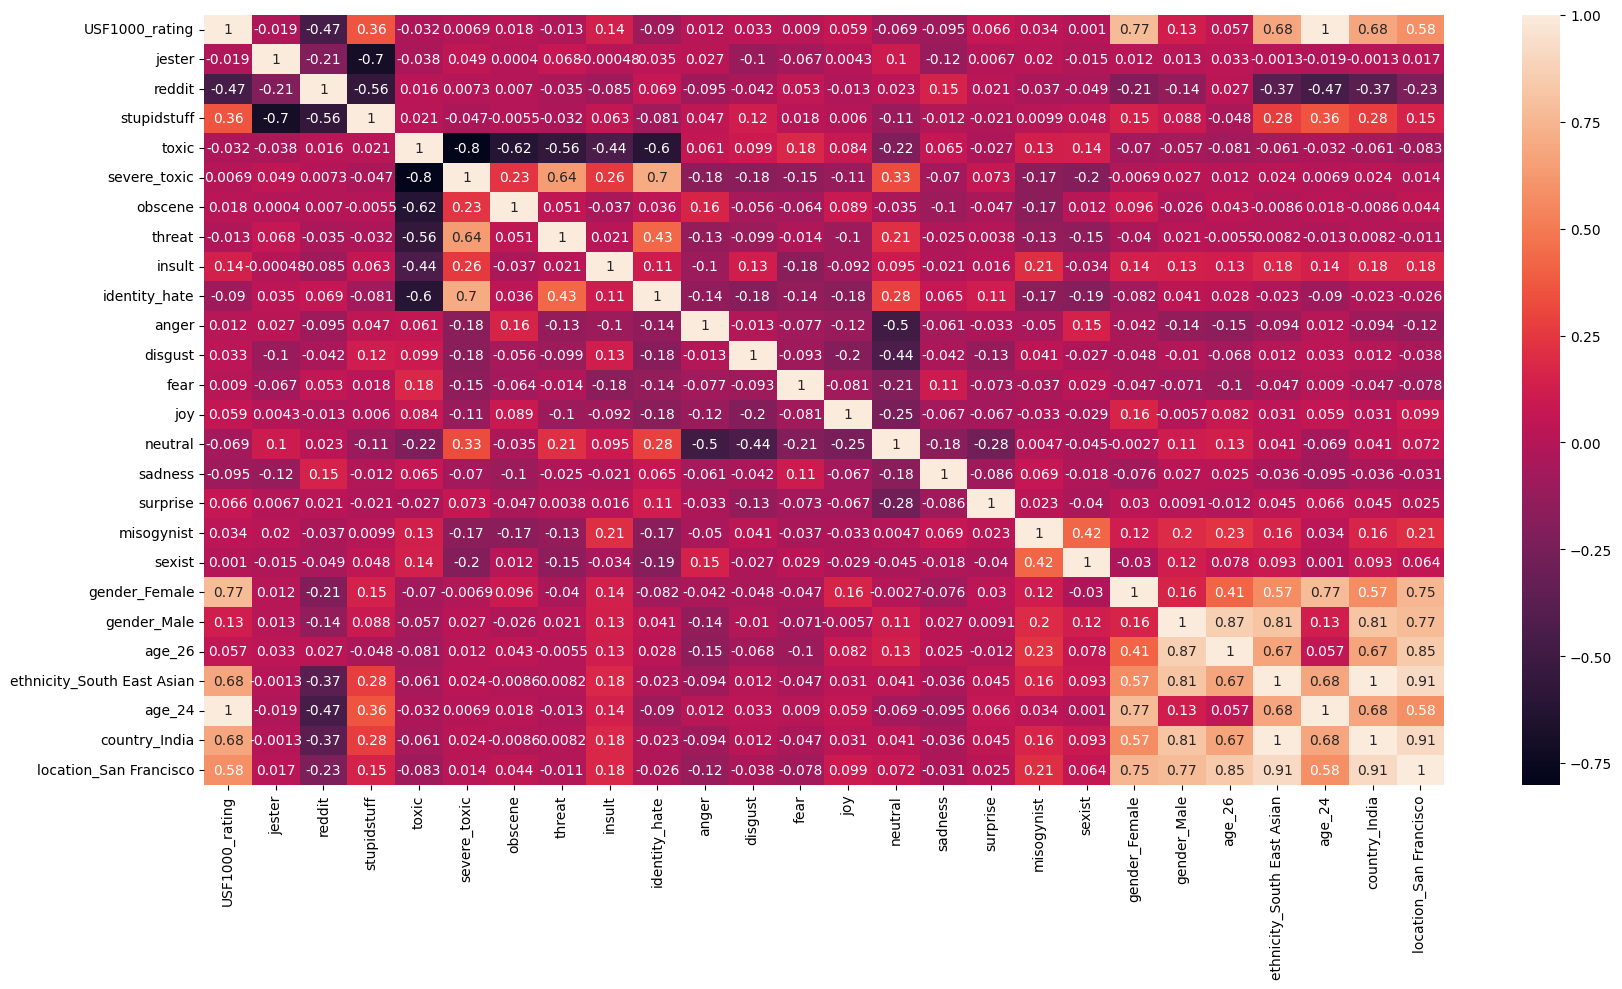

In [79]:
# jokes_df_corr = abs(corr(jokes_df))
plt.figure(figsize=(20,10))
sns.heatmap(jokes_df.corr(), annot=True)

In [40]:
from sklearn.model_selection import train_test_split

label_df_buddy = jokes_df[target_user_traits['user_id'] + '_rating']
jokes_df = jokes_df.drop([target_user_traits['user_id'] + '_rating', target_user_traits['user_id'] + '_rating'], axis=1)

X_train_buddy, X_test_buddy, y_train_buddy, y_test_buddy = train_test_split(jokes_df, label_df_buddy , test_size=0.1, random_state=42)

In [41]:
X_test_buddy

,jester,reddit,stupidstuff,toxic,severe_toxic,obscene,threat,insult,identity_hate,anger,...,surprise,misogynist,sexist,gender_Female,gender_Male,age_26,ethnicity_South East Asian,age_24,country_India,location_San Francisco
30,0,1,0,0.862124,0.004852,0.034576,0.009541,0.070019,0.018888,0.069142,...,0.059979,0.000189,0.014486,0.166667,0.333333,0.333333,0.500000,0.166667,0.500000,0.500000
140,0,0,1,0.903874,0.001181,0.011664,0.010225,0.070254,0.002801,0.272467,...,0.020111,0.000825,0.053721,0.000000,0.200000,0.200000,0.200000,0.000000,0.200000,0.200000
170,0,0,1,0.795062,0.018083,0.058903,0.030519,0.056882,0.040551,0.178989,...,0.637177,0.000309,0.009145,0.333333,0.066667,0.066667,0.400000,0.333333,0.400000,0.400000
101,0,0,1,0.714196,0.032045,0.076423,0.038885,0.074358,0.064093,0.022738,...,0.045030,0.000362,0.033472,0.200000,0.333333,0.333333,0.533333,0.200000,0.533333,0.533333
241,0,0,1,0.894499,0.002175,0.022572,0.005462,0.065845,0.009445,0.019413,...,0.003774,0.000152,0.016929,0.233333,0.300000,0.300000,0.533333,0.233333,0.533333,0.533333
208,0,0,1,0.869113,0.006563,0.041573,0.013593,0.050324,0.018834,0.862425,...,0.008823,0.000272,0.031400,0.266667,0.100000,0.100000,0.366667,0.266667,0.366667,0.366667
235,0,0,1,0.886499,0.001410,0.012330,0.001517,0.090922,0.007322,0.007454,...,0.008973,0.252094,0.041335,0.200000,0.066667,0.066667,0.266667,0.200000,0.266667,0.266667
177,0,0,1,0.724773,0.028892,0.086834,0.035857,0.072523,0.051122,0.012889,...,0.003701,0.000278,0.016235,0.233333,0.333333,0.333333,0.566667,0.233333,0.566667,0.566667
231,0,0,1,0.446673,0.090163,0.139510,0.085658,0.133905,0.104089,0.001403,...,0.019073,0.000238,0.010199,0.266667,0.300000,0.300000,0.566667,0.266667,0.566667,0.566667
192,0,0,1,0.829435,0.011891,0.042872,0.018780,0.059474,0.037548,0.009261,...,0.007191,0.000315,0.015777,0.333333,0.133333,0.133333,0.466667,0.333333,0.466667,0.466667


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


# params = {'max_depth': [3, 4, 5], # Go smaller
#           'criterion': ['entropy', 'gini'],
#           'n_estimators': [115, 130, 150], # Go smaller, 3/5/10,x,
#           'max_features': [None]
#         }

# params = {'max_depth': [None, 5, 10, 20, 30], 
#           'criterion': ['absolute_error', 'squared_error'],
#           'n_estimators': [115, 130, 150, 200], 
#           'max_features': [None, 'log2']
#         }

params = {
    'max_depth': [5, 10, 9],
    'n_estimators': [50, 150, 200]
}


folds = 5
rf_buddy = RandomForestRegressor()

clf = GridSearchCV(rf_buddy, params, cv=folds, n_jobs=-1)

clf.fit(X_train_buddy, y_train_buddy)
print(clf.best_params_)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Train the model with the best parameters obtained

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rf = RandomForestRegressor(**clf.best_params_, random_state=42, n_jobs=-1)

rf.fit(X_train_buddy, y_train_buddy)
y_pred = rf.predict(X_test_buddy)

accuracy = rf.score(X_test_buddy, y_test_buddy)
print("Accuracy->", accuracy)

rmse = mean_squared_error(y_test_buddy, y_pred, squared=False)
print("RMSE->", rmse)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [43]:
X_test_buddy

,jester,reddit,stupidstuff,toxic,severe_toxic,obscene,threat,insult,identity_hate,anger,...,surprise,misogynist,sexist,gender_Female,gender_Male,age_26,ethnicity_South East Asian,age_24,country_India,location_San Francisco
30,0,1,0,0.862124,0.004852,0.034576,0.009541,0.070019,0.018888,0.069142,...,0.059979,0.000189,0.014486,0.166667,0.333333,0.333333,0.500000,0.166667,0.500000,0.500000
140,0,0,1,0.903874,0.001181,0.011664,0.010225,0.070254,0.002801,0.272467,...,0.020111,0.000825,0.053721,0.000000,0.200000,0.200000,0.200000,0.000000,0.200000,0.200000
170,0,0,1,0.795062,0.018083,0.058903,0.030519,0.056882,0.040551,0.178989,...,0.637177,0.000309,0.009145,0.333333,0.066667,0.066667,0.400000,0.333333,0.400000,0.400000
101,0,0,1,0.714196,0.032045,0.076423,0.038885,0.074358,0.064093,0.022738,...,0.045030,0.000362,0.033472,0.200000,0.333333,0.333333,0.533333,0.200000,0.533333,0.533333
241,0,0,1,0.894499,0.002175,0.022572,0.005462,0.065845,0.009445,0.019413,...,0.003774,0.000152,0.016929,0.233333,0.300000,0.300000,0.533333,0.233333,0.533333,0.533333
208,0,0,1,0.869113,0.006563,0.041573,0.013593,0.050324,0.018834,0.862425,...,0.008823,0.000272,0.031400,0.266667,0.100000,0.100000,0.366667,0.266667,0.366667,0.366667
235,0,0,1,0.886499,0.001410,0.012330,0.001517,0.090922,0.007322,0.007454,...,0.008973,0.252094,0.041335,0.200000,0.066667,0.066667,0.266667,0.200000,0.266667,0.266667
177,0,0,1,0.724773,0.028892,0.086834,0.035857,0.072523,0.051122,0.012889,...,0.003701,0.000278,0.016235,0.233333,0.333333,0.333333,0.566667,0.233333,0.566667,0.566667
231,0,0,1,0.446673,0.090163,0.139510,0.085658,0.133905,0.104089,0.001403,...,0.019073,0.000238,0.010199,0.266667,0.300000,0.300000,0.566667,0.266667,0.566667,0.566667
192,0,0,1,0.829435,0.011891,0.042872,0.018780,0.059474,0.037548,0.009261,...,0.007191,0.000315,0.015777,0.333333,0.133333,0.133333,0.466667,0.333333,0.466667,0.466667


In [51]:
y_test_buddy

30      5.0
140     0.0
170    10.0
101     6.0
241     7.0
208     8.0
235     6.0
177     7.0
231     8.0
192    10.0
64      9.0
124    10.0
202     7.0
239     7.0
131    10.0
116     9.0
175     6.0
60      8.0
66      7.0
213     3.0
45      6.0
63      8.0
154     7.0
206     6.0
236     7.0
184     7.0
91      7.0
42      4.0
Name: USF1000_rating, dtype: float64

In [65]:
# get users_demographics dataframe's joke text at all the indices in X_test_buddy

test_joke_texts = users_demographics.iloc[X_test_buddy.index]['jokeText']

In [76]:
print(f"\n{x[idx].jokeText}" for idx,x in test_joke_texts)

<generator object <genexpr> at 0x165032650>


In [77]:
test_joke_texts

30     A rugby player was hurt very badly during a sc...
116    A Jewish father was concerned about his son wh...
146    A large two engine train was crossing America....
77     What is the difference between men and women:\...
217    The soldiers are tired and lonely after spendi...
184    Q: How many surrealists does it take to change...
211    A man takes his dog to the Vet and says, "Doct...
153    The devil visited a lawyer's office and made h...
207    A Brunette, a Redhead, and a Blonde escape a b...
168    A group of tourists was being guided through a...
61     Q: What is the Australian word for a boomerang...
100    Lets play house. You be the door and I'll slam...
178    Upon landing hard, the pilot got on the PA sys...
215    Two bored casino dealers are waiting at a crap...
107    One Sunday morning, the priest noticed that li...
92     At a dinner party, several of the guests were ...
151    A 54 year old accountant leaves a letter for h...
60     A duck walks into a phar

In [73]:
print(test_joke_texts[91])

KeyError: 91